## Liveability index

#### This code explores the data further and develops a "liveability index" that shows how great a place will be in the future with regards to climate change

In [93]:
# import reqs
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import datetime, statsmodels, warnings
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose 
warnings.simplefilter("ignore")
from math import sqrt
from datetime import date, timedelta
from matplotlib.ticker import StrMethodFormatter

In [3]:
# import cleaned data (will be replaced with sql commands once downstream analysis portion has been completed)
# this needs to communicate and pull the data from the SQL server
num_heating_days_state = pd.read_csv('processed_data/num_heating_days_state.csv')
num_cooling_days_state = pd.read_csv('processed_data/num_cooling_days_state.csv')
preciptation_state = pd.read_csv('processed_data/preciptation_state.csv')
temperature_avg_state = pd.read_csv('processed_data/temperature_avg_state.csv')
temperature_max_state = pd.read_csv('processed_data/temperature_max_state.csv')
temperature_min_state = pd.read_csv('processed_data/temperature_min_state.csv')

# make the data frame
num_heating_days_state = pd.DataFrame(num_heating_days_state)
num_cooling_days_state = pd.DataFrame(num_cooling_days_state)
preciptation_state = pd.DataFrame(preciptation_state)
temperature_avg_state = pd.DataFrame(temperature_avg_state)
temperature_max_state = pd.DataFrame(temperature_max_state)
temperature_min_state = pd.DataFrame(temperature_min_state)

# list the column names to be working with
print(num_heating_days_state.columns)
print(len(num_heating_days_state))

Index(['col_num', 'ClimDivCode_x', 'fips_code_start', 'weather_data_type',
       'year', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sept',
       'oct', 'nov', 'dec', 'NCDC_FIPS_ID', 'ClimDivCode_y', 'ActualDivCode',
       'StateName', 'FIPS code', 'name', 'State Code', 'CLIMDIV_ID'],
      dtype='object')
399771


In [5]:
# select the state and county you want by entering its name, matches with the county name and state
def select_data(df, val1, val2):
    """Helper function to match the State Name and County"""
    result = df[(df["StateName"] == val1) & (df["name"].str.contains(val2 + " County"))]
    if result.empty:
        return "Error no matching data was found"
    else:
        return result

### To run the stats we are going to be looking at my home county where I grew up Forsyth County Georgia

In [127]:
# select subset of data to begin building the model, should be cleared later when functionality is built out
# dont forget to not include NaN values in the analysis, these should not be included in the count
heat = select_data(num_heating_days_state, "Georgia", "Forsyth")
cool = select_data(num_cooling_days_state, "Georgia", "Forsyth")
precip = select_data(preciptation_state, "Georgia", "Forsyth")
temp_a = select_data(temperature_avg_state, "Georgia", "Forsyth")
temp_max = select_data(temperature_max_state, "Georgia", "Forsyth")
temp_min = select_data(temperature_min_state, "Georgia", "Forsyth")

In [147]:
def basic_stats(df, year, *columns):
    """Function calculates mean and std dev, then uses that to calcualte z-scores to find how far
    from the mean each value is, will return the z-scores"""
    relevant_df = df[['year'] + list(columns)]
    stats = relevant_df.describe().loc[['mean', 'std']]
    z_scores = (relevant_df.drop(columns=['year']) - stats.loc['mean']) / stats.loc['std']
    z_scores['year'] = relevant_df['year']
    cols = ['year'] + list(columns)
    z_scores = z_scores[cols]
    return z_scores

heater_z = pd.DataFrame(basic_stats(heat, "year", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec")).fillna(0)
cooler_z = pd.DataFrame(basic_stats(cool, "year", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec")).fillna(0)
precip_z = pd.DataFrame(basic_stats(precip, "year", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec")).fillna(0)
temp_a_z = pd.DataFrame(basic_stats(temp_a, "year", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec")).fillna(0)
temp_max_z = pd.DataFrame(basic_stats(temp_max, "year", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec")).fillna(0)
temp_min_z = pd.DataFrame(basic_stats(temp_min, "year", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec")).fillna(0)

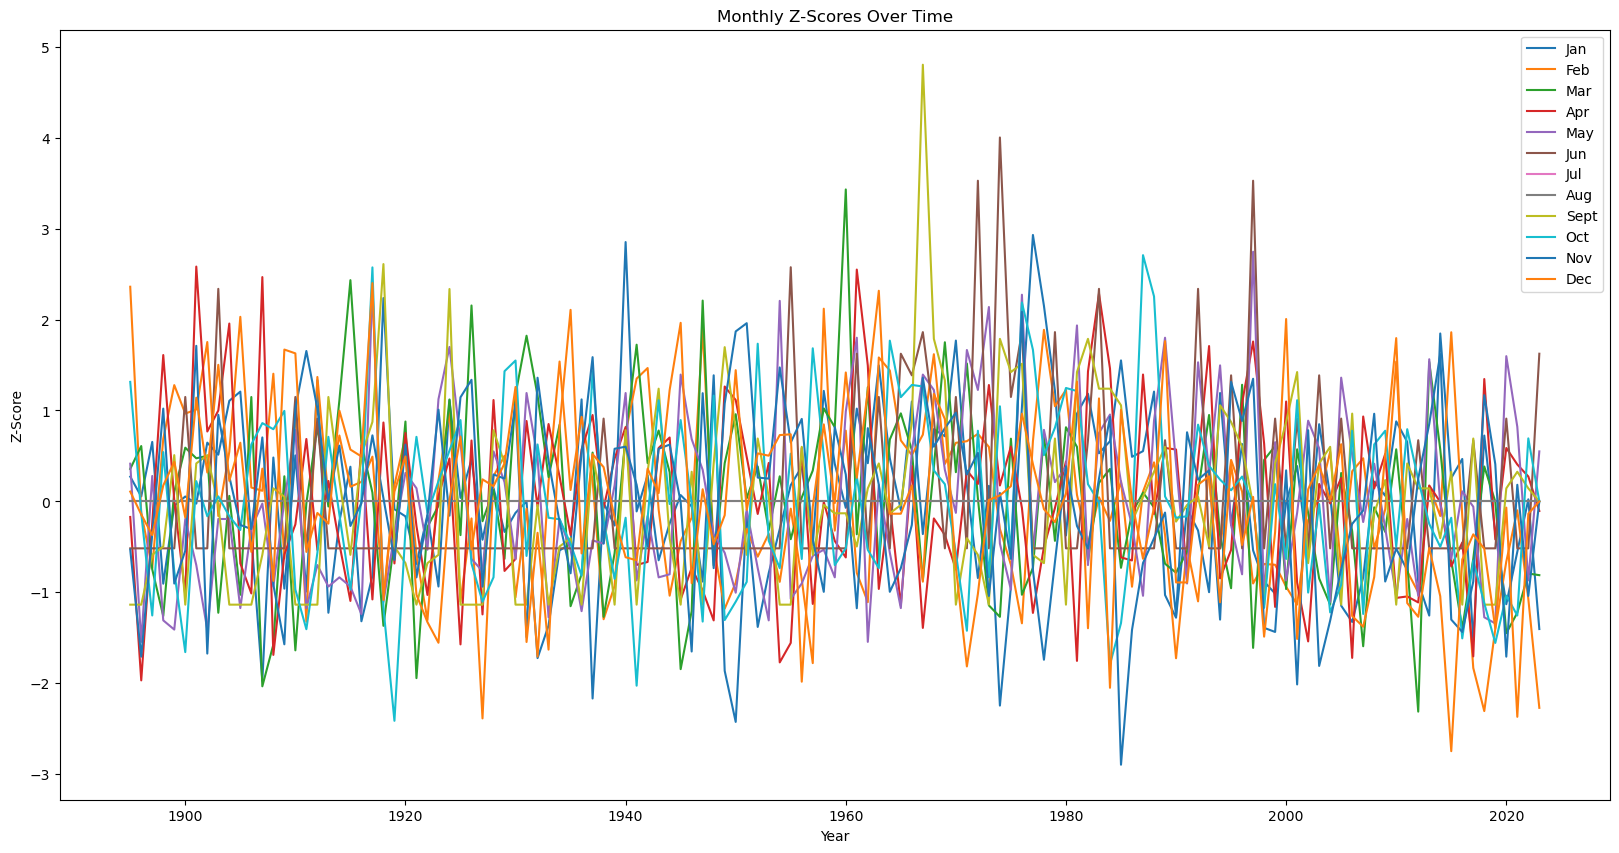

In [129]:
def plot_monthly_z_scores(df):
    """Will plot monthly z_scores on one graph given the proper dataframe"""
    plt.figure(figsize=(20, 10))
    # Assuming the exact names of the months are as listed and 'year' is correctly named
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sept', 'oct', 'nov', 'dec']
    for month in months:
        plt.plot(df['year'], df[month], label = month.capitalize())
    plt.xlabel('Year')
    plt.ylabel('Z-Score')
    plt.title('Monthly Z-Scores Over Time')
    plt.legend()
    plt.show()

plot_monthly_z_scores(data)

### Building Training and Valid Data

In [148]:
def prep_time_series(df, value_name = 'value'):
    """Use this function to transform to a time series with a single column"""
    df_long = df.melt(id_vars=['year'], var_name='month', value_name=value_name) # melt to distribute the values to long format
    month_to_num = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                    'jul': 7, 'aug': 8, 'sept': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    df_long['month'] = df_long['month'].map(month_to_num) # map each to numbers
    df_long['date'] = pd.to_datetime(df_long[['year', 'month']].assign(DAY=1))
    df_long = df_long.sort_values('date')
    df_long.set_index('date', inplace=True)
    df_long.drop(['year', 'month'], axis=1, inplace=True)
    return df_long

heater_z_prep = prep_time_series(heater_z, "z-score")

In [149]:
# divide the data into two separate sets
Train = heater_z_prep[heater_z_prep.index.year < 1980].reset_index()
Valid = heater_z_prep[heater_z_prep.index.year >= 1980].reset_index()

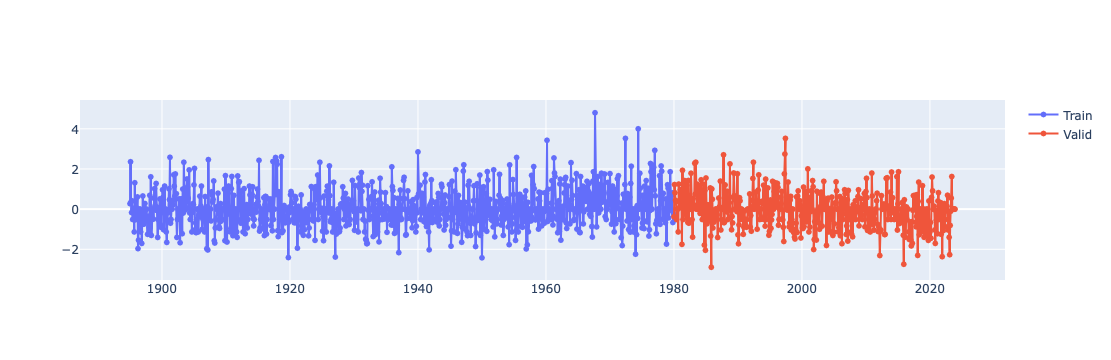

In [132]:
# visualize data as training and valid data for further downstream analysis
fig = go.Figure()
fig.add_trace(go.Scatter(x=Train['date'], y=Train['z-score'], mode='lines+markers', name='Train'))
fig.add_trace(go.Scatter(x=Valid['date'], y=Valid['z-score'], mode='lines+markers', name='Valid'))

fig.update_layout(title_text="Monthly Z-Scores for 1960–2023", title_x=0.5,
                  margin=dict(l=10, r=0, t=50, b=50),
                  xaxis_title_text="date",
                  xaxis=dict(tickmode='linear', tick0=1895, dtick=10),
                  yaxis_title_text="Z-Score")

fig.show()

### Seasonal Decomposition of climate data heating days

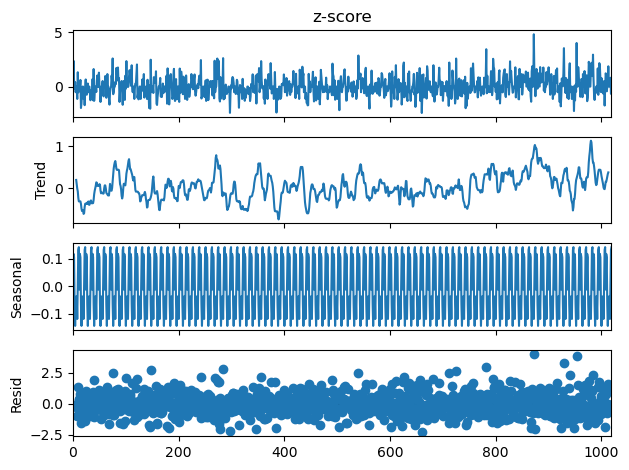

In [133]:
result = seasonal_decompose(Train['z-score'], model='additive', period=12)
result.plot()
plt.show()

### Calculating 12 month Rolling Mean and Rolling Standard Deviations

In [135]:
def rolling_graph(d1, d2):
    """Generates rolling mean and std dev from generated z-scores and time series data, requires
    two inputs, d1 is your data and date, d2 is your data and z scores"""
    window_size = 12
    rol_mean = d2.rolling(window=window_size, min_periods=1).mean()
    rol_std = d2.rolling(window=window_size, min_periods=1).std()
    # create the plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=d1, y=d2, mode='lines+markers', name='Original Data'))
    fig.add_trace(go.Scatter(x=d1, y=rol_mean, mode='lines', name='Rolling Mean'))
    fig.add_trace(go.Scatter(x=d1, y=rol_std, mode='lines', name='Rolling Standard Deviation'))

    # format the layout
    fig.update_layout(
        title='Rolling Mean, Standard Deviation of Z-Scores',
        xaxis_title="Date",
        yaxis_title="Climate Change Value",
        xaxis=dict(
            type='date',
            tickformat='%Y-%m-%d', #year month day format
            rangeslider=dict(visible=True),
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(count=10, label="10y", step="year", stepmode="backward"),
                    dict(count=25, label="25y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            )
        ),
        yaxis=dict(
            title_font=dict(family="Courier New, monospace", size=18, color="#7f7f7f")
        )
    )
    fig.show()

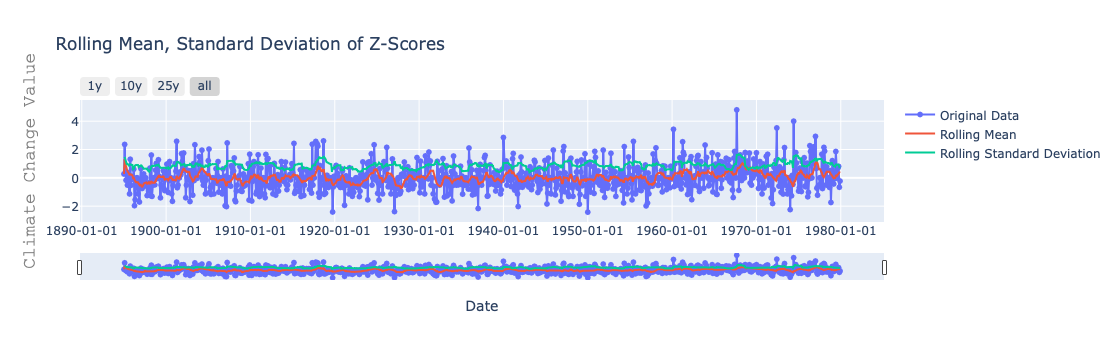

In [136]:
# conducting analysis on training data
rolling_graph(Train['date'], Train['z-score'])

In [137]:
# data is obviously not stationary because it is flucatuating around 0 multiple times

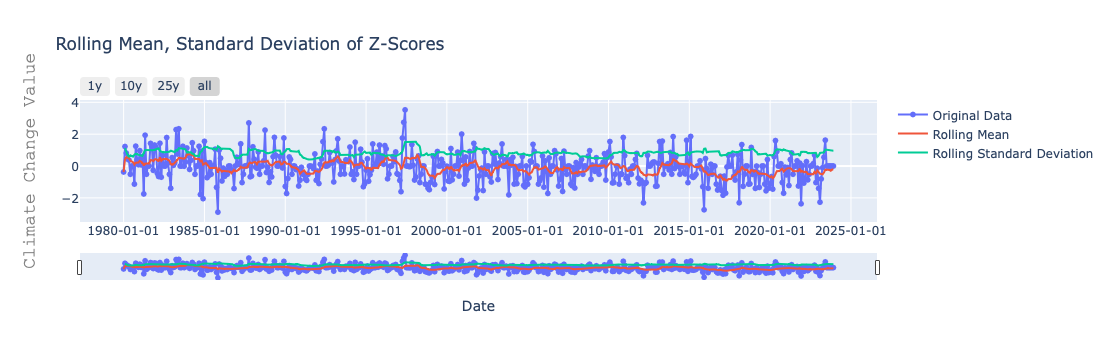

In [138]:
# now to do it on the valid data
rolling_graph(Valid['date'], Valid['z-score'])

### Building the SARIMAX model

In [142]:
window_size = 12

Train = heater_z_prep[heater_z_prep.index.year < 1980].reset_index()
Valid = heater_z_prep[heater_z_prep.index.year >= 1980].reset_index()

# Calculate rolling mean and standard deviation with a window of 12 months for example
Train['rolling_mean'] = Train['z-score'].rolling(window=window_size).mean().fillna(0)
Train['rolling_std'] = Train['z-score'].rolling(window=window_size).std().fillna(0)

last_train_values = Train.iloc[-(window_size-1):]
Valid_combined = pd.concat([last_train_values, Valid])

Valid['rolling_mean'] = Valid_combined['z-score'].rolling(window=window_size).mean().fillna(0).iloc[-len(Valid):]
Valid['rolling_std'] = Valid_combined['z-score'].rolling(window=window_size).std().fillna(0).iloc[-len(Valid):]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39337D+00    |proj g|=  3.02789D-01

At iterate    5    f=  1.29515D+00    |proj g|=  3.86701D-02

At iterate   10    f=  1.28940D+00    |proj g|=  2.85671D-03

At iterate   15    f=  1.28920D+00    |proj g|=  1.41946D-03

At iterate   20    f=  1.28920D+00    |proj g|=  5.89718D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     23      1     0     0   5.897D-05   1.289D+00
  F =   1.2891962610874426     

CONVERG

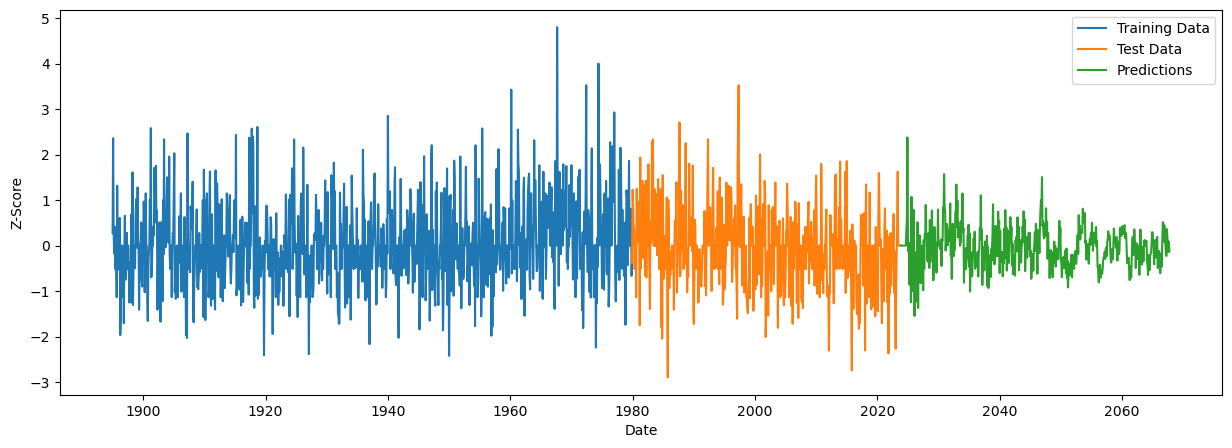

In [145]:
# Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors Model (period of 12 denoting 1 year)

def sarimax_model(data):
    window_size = 12
    last_train_values = Train.iloc[-(window_size-1):]
    Valid_combined = pd.concat([last_train_values, Valid])
    Valid['rolling_mean'] = Valid_combined['z-score'].rolling(window=window_size).mean().fillna(0).iloc[-len(Valid):]
    Valid['rolling_std'] = Valid_combined['z-score'].rolling(window=window_size).std().fillna(0).iloc[-len(Valid):]
    
    # Define and fit the SARIMAX model using the Train set and include the exogenous variables
    model = SARIMAX(Train['z-score'], exog=Train[['rolling_mean', 'rolling_std']], 
                    order=(1, 0, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit()
    
    # Predict on the Valid set
    Valid['predictions'] = results.get_prediction(start=Valid.index[0], end=Valid.index[-1], 
                                                  exog=Valid[['rolling_mean', 'rolling_std']]).predicted_mean

def plot_sarimax(data):
    # Plot the results
    plt.figure(figsize=(15, 5))
    
    # Plot training data
    plt.plot(Train['date'], Train['z-score'], label='Training Data')
    
    # Plot test data, making sure it's continuous with the training data
    last_train_date = Train['date'].iloc[-1]
    first_test_date = Valid['date'].iloc[0]
    
    # Create a continuous date range for the test data
    test_dates = pd.date_range(start=last_train_date, 
                               periods=len(Valid), 
                               freq='MS')  # Assuming monthly frequency
    
    plt.plot(test_dates, Valid['z-score'], label='Test Data')
    
    # Plot predictions, making sure it's continuous with the test data
    prediction_dates = pd.date_range(start=test_dates[-1], 
                                     periods=len(Valid), 
                                     freq='MS')  # Assuming monthly frequency for predictions as well
    
    plt.plot(prediction_dates, Valid['predictions'], label='Predictions')
    
    # Formatting the plot
    plt.xlabel('Date')
    plt.ylabel('Z-Score')
    plt.legend()
    plt.show()

### Plotting a linear regression over the valid and predicted trend to see generally where the trend will take us

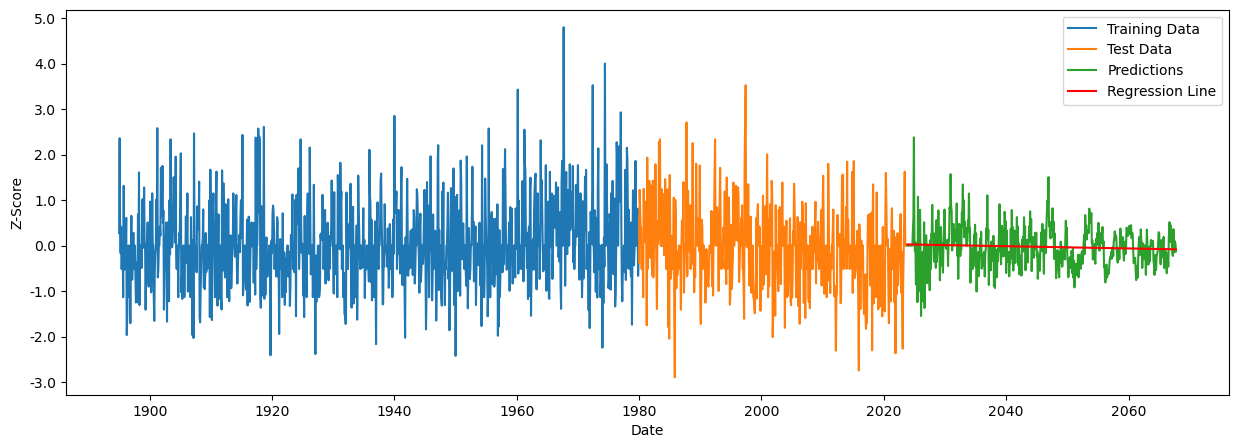

-0.0000067151


In [146]:

prediction_dates_ordinal = np.array([d.toordinal() for d in prediction_dates])
slope, intercept = np.polyfit(prediction_dates_ordinal, Valid['predictions'], 1) # perform lin reg on predicted
regression_line = slope * prediction_dates_ordinal + intercept #regression equation to get the y values

plt.figure(figsize=(15, 5)) #plot
plt.plot(Train['date'], Train['z-score'], label='Training Data') #training data
plt.plot(Valid['date'], Valid['z-score'], label='Test Data') #test data
plt.plot(prediction_dates, Valid['predictions'], label='Predictions') #pred data
plt.plot(prediction_dates, regression_line, label='Regression Line', color='red') #plot reg line over pred

# format
ax = plt.gca()
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))

# Set labels and legend
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()

# Show the plot
plt.show()

# Print the slope value with fixed-point notation
formatted_slope_value = f"{slope:.10f}"
print(formatted_slope_value)

### Will need to adjust model on what is considered 'climate stable places', we should be looking at how much wobble there is going to be, not a direct trend up or down, a higher slope or lower slope value will mean more climate change in general, not one way or the other

#### Final Model will run this analysis on all parts of the dataset and weight each set accordingly. Heat and cooling days will be of most importance, then precip, then avg temp, then max/min. 50% (50/50), 25%, 12.5%, and 6.25, 6.25 respectively fort everything. Closer to zero would should more climatoglocially stable place, closer to 100 should show more wild weather. Also want to show the rolling averages on the site as well